In [51]:
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def variance_per_column_2(column):
    tracker_ratio = train_data[train_data[column].notnull()].tracker.value_counts()
    try:
        trackers = tracker_ratio[1]
    except KeyError:
        trackers = 0
    try:
        non_trackers = tracker_ratio[0]
    except KeyError:
        non_trackers = 0
    return [column, trackers, non_trackers]

In [3]:
train_data = pd.read_parquet("../data/processed/chrome/08_12_2022/train_set_01_processed.parquet.gzip")
# test_data = pd.read_parquet("../data/processed/test_set_0.parquet.gzip")
# X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
# X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

In [69]:
train_data

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,x-b3-sampled,x-b3-spanid,x-hubspot-correlation-id,x-hs-target-asset,x-hostname,x-cdn-pop,x-cdn-pop-ip,header_count,comb_col_non_tracker,comb_col_tracker
0,tpc.googlesyndication.com,/pagead/js/r20220810/r20110914/client/one_clic...,js,one_click_handler_one_afma_fy2021.js,NaN,text/javascript; charset=utf-8,"sun, 17 may 1998 03:00:00 gmt",bytes,15601544113783900868,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,0,0
1,res.cdn.office.net,/officehub/bundles/staying-aware.b8b088b355c55...,js,staying-aware.b8b088b355c55b4ea7d6.chunk.v6.js,NaN,application/javascript,"mon, 08 aug 2022 21:56:59 gmt",bytes,0x8da7b64a03a8ae5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,1,0
2,www.google.com,/ads/ga-audiences,/ads/ga-audiences,ga-audiences,no-cache,image/gif,"sun, 17 may 1998 03:00:00 gmt",bytes,12862140795212465669,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,0,0
3,ipv4-c113-lhr004-ix.1.oca.nflxvideo.net,/speedtest/range/0-0,/speedtest/range/0-0,0-0,no-cache,image/jpeg,"thu, 11 aug 2022 21:41:37 gmt",bytes,0x8da7b64a03a8ae5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1,0
4,shimo.im,/,/,,NaN,text/html; charset=utf-8,"thu, 11 aug 2022 21:41:37 gmt",bytes,0x8da7b64a03a8ae5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253781,www.criteo.com,/wp-content/uploads/2021/01/ss-logo-Lamps-Plus...,png,ss-logo-Lamps-Plus.png,NaN,image/png,"fri, 12 nov 2021 05:09:38 gmt",bytes,"""618df712-2509""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,1,0
253782,ads.adfox.ru,/260122/event,/260122/event,event,no-cache,image/gif,"fri, 12 aug 2022 09:22:13 gmt",bytes,12862140795212465669,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0,0
253783,synostatic.synology.com,/font/inter/inter-w400-6.woff2,woff2,inter-w400-6.woff2,NaN,binary/octet-stream,"mon, 20 dec 2021 02:24:19 gmt",bytes,"""4abfa4888190370d347034f9fa43c804""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0,0
253784,tenor.com,/opensearch.xml,xml,opensearch.xml,NaN,application/xml,"thu, 26 apr 2018 18:25:27 gmt",bytes,"w/""29a-1630333f5d8""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,1,0


In [4]:
number_of_elements_reduced = np.array(
    [variance_per_column_2(column) for column in train_data.iloc[:, 4:-4].columns]
)
summary_table = pd.DataFrame(
    number_of_elements_reduced, columns=["header_name", "trackers", "non_trackers"]
)
summary_table["trackers"] = summary_table["trackers"].astype("Int32")
summary_table["non_trackers"] = summary_table["non_trackers"].astype("float32")

In [82]:
summary_table

,header_name,trackers,non_trackers
0,pragma,20676,7902.0
1,content-type,60371,185274.0
2,last-modified,25139,150164.0
3,accept-ranges,13512,113677.0
4,etag,16516,126917.0
...,...,...,...
146,x-hubspot-correlation-id,127,267.0
147,x-hs-target-asset,63,76.0
148,x-hostname,115,61.0
149,x-cdn-pop,17,122.0


In [5]:
def test_new_categories_update(element):
    categories = train_data[element].astype("category").cat.categories.values.tolist()
    try:
        np.array(categories, dtype="int64")
        return {element: "Int64"}
    except (ValueError, OverflowError):
        return None

In [6]:
columns_as_category = {i: "category" for i in train_data.columns.values[:-4]}
column_test = train_data.columns.values[4:-4].tolist()
braze2 = [test_new_categories_update(element) for element in column_test]

braze2 = list(filter(lambda x: type(x) is dict, braze2))
braze2 = {k: v for d in braze2 for k, v in d.items()}

columns_as_category.update(braze2)
train_data = train_data.astype(columns_as_category)

In [7]:
list_of_categorical_cols = list(train_data.iloc[:, 4:-4].select_dtypes('category').columns.values.tolist())
list_of_integer_cols = list(train_data.iloc[:, 4:-4].select_dtypes('Int64').columns.values.tolist())

number_of_trackers = len(train_data[train_data['tracker'] == 1])
number_of_non_trackers = len(train_data[train_data['tracker'] == 0])
summary_table['ratio_tracker'] = summary_table['trackers'] / number_of_trackers
summary_table['ratio_non_tracker'] = summary_table['non_trackers'] / number_of_non_trackers

impute_col_list_t = summary_table[summary_table['ratio_tracker'] > 0.4].header_name.values.tolist()
impute_col_list_nt = summary_table[summary_table['ratio_non_tracker'] > 0.4].header_name.values.tolist()

In [8]:
def impute_value(element, classification):
    if element in list_of_integer_cols:
        train_data.loc[train_data['tracker'] == classification, element] = train_data.loc[train_data['tracker'] ==
                                                                                          classification, element]\
            .fillna(int(train_data[train_data['tracker']==classification][element].median()))

    if element in list_of_categorical_cols:
        train_data.loc[train_data['tracker'] == classification, element] = train_data.loc[train_data['tracker'] ==
                                                                                          classification, element]\
            .fillna(train_data[train_data['tracker']==classification][element].mode().iloc[0])

In [9]:
for header in impute_col_list_t:
    impute_value(header, 0)

for header in impute_col_list_t:
    impute_value(header, 1)

for header in impute_col_list_nt:
    impute_value(header, 1)

for header in impute_col_list_nt:
    impute_value(header, 0)

Train dummy classifier

In [10]:
y_train = train_data[['tracker']]

In [11]:
train_data.drop('tracker', axis=1, inplace=True)

In [12]:
X_train = train_data

In [98]:
%%time
dummy_clf = DummyClassifier(strategy="uniform", random_state=10)
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_train, y_train)

CPU times: user 23.7 ms, sys: 1.14 ms, total: 24.8 ms
Wall time: 24.7 ms


0.4994050105206749

In [60]:
y_train.dtypes

tracker    int32
dtype: object

In [64]:
model = xgb.XGBClassifier()

In [15]:
X_train_2 = X_train.dropna(axis=1, how='any').iloc[:, 4:]

In [65]:
model.fit(X_train_2, test)

/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:content-length

In [148]:
preprocessing.OneHotEncoder().fit_transform(X_train_2)

<253786x424659 sparse matrix of type '<class 'numpy.float64'>'
	with 4314362 stored elements in Compressed Sparse Row format>

In [13]:
label_encoder = preprocessing.LabelEncoder()

In [17]:
X_train_2.drop(['date'], axis=1, inplace=True)

In [61]:
X_train_2.dtypes

content-type                   int64
last-modified                  int64
accept-ranges                  int64
etag                           int64
vary                           int64
content-encoding               int64
cache-control                  int64
expires                        int64
content-length                 Int64
server                         int64
age                            int64
alt-svc                        int64
access-control-allow-origin    int64
header_count                   int64
comb_col_non_tracker           int64
comb_col_tracker               int64
dtype: object

In [20]:
X_train_2['content-type'] = label_encoder.fit_transform(X_train_2['content-type'])
X_train_2['last-modified'] = label_encoder.fit_transform(X_train_2['last-modified'])
X_train_2['accept-ranges'] = label_encoder.fit_transform(X_train_2['accept-ranges'])
X_train_2['etag'] = label_encoder.fit_transform(X_train_2['etag'])
X_train_2['vary'] = label_encoder.fit_transform(X_train_2['vary'])
X_train_2['content-encoding'] = label_encoder.fit_transform(X_train_2['content-encoding'])
X_train_2['cache-control'] = label_encoder.fit_transform(X_train_2['cache-control'])
X_train_2['expires'] = label_encoder.fit_transform(X_train_2['expires'])
X_train_2['server'] = label_encoder.fit_transform(X_train_2['server'])
X_train_2['age'] = label_encoder.fit_transform(X_train_2['age'])
X_train_2['alt-svc'] = label_encoder.fit_transform(X_train_2['alt-svc'])
X_train_2['access-control-allow-origin'] = label_encoder.fit_transform(X_train_2['access-control-allow-origin'])

In [22]:
rf = RandomForestClassifier()

In [34]:
test = y_train['tracker'].to_numpy()

In [35]:
rf.fit(X_train_2, test)

RandomForestClassifier()

In [36]:
importance = rf.feature_importances_

In [47]:
d = {"header": X_train_2.columns.values.tolist(), "value": importance.tolist()}

<AxesSubplot:xlabel='header', ylabel='value'>

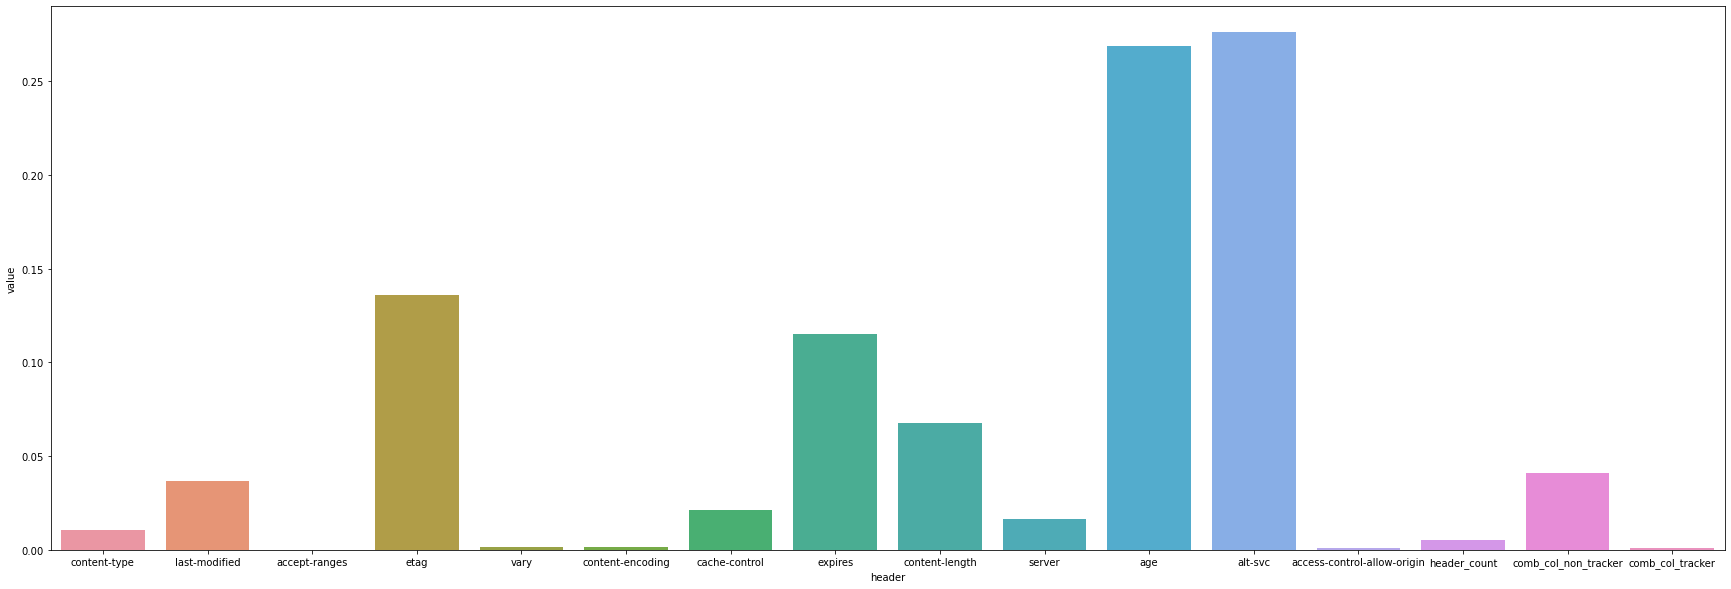

In [54]:
%matplotlib inline
plt.figure(figsize=(30, 10))
sns.barplot(data=pd.DataFrame(d), x='header', y='value')

In [67]:
rf.score(X_train_2, test)

0.9999960596723223

In [68]:
X_train

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,x-b3-sampled,x-b3-spanid,x-hubspot-correlation-id,x-hs-target-asset,x-hostname,x-cdn-pop,x-cdn-pop-ip,header_count,comb_col_non_tracker,comb_col_tracker
0,tpc.googlesyndication.com,/pagead/js/r20220810/r20110914/client/one_clic...,js,one_click_handler_one_afma_fy2021.js,NaN,text/javascript; charset=utf-8,"sun, 17 may 1998 03:00:00 gmt",bytes,15601544113783900868,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,0,0
1,res.cdn.office.net,/officehub/bundles/staying-aware.b8b088b355c55...,js,staying-aware.b8b088b355c55b4ea7d6.chunk.v6.js,NaN,application/javascript,"mon, 08 aug 2022 21:56:59 gmt",bytes,0x8da7b64a03a8ae5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,1,0
2,www.google.com,/ads/ga-audiences,/ads/ga-audiences,ga-audiences,no-cache,image/gif,"sun, 17 may 1998 03:00:00 gmt",bytes,12862140795212465669,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,0,0
3,ipv4-c113-lhr004-ix.1.oca.nflxvideo.net,/speedtest/range/0-0,/speedtest/range/0-0,0-0,no-cache,image/jpeg,"thu, 11 aug 2022 21:41:37 gmt",bytes,0x8da7b64a03a8ae5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1,0
4,shimo.im,/,/,,NaN,text/html; charset=utf-8,"thu, 11 aug 2022 21:41:37 gmt",bytes,0x8da7b64a03a8ae5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253781,www.criteo.com,/wp-content/uploads/2021/01/ss-logo-Lamps-Plus...,png,ss-logo-Lamps-Plus.png,NaN,image/png,"fri, 12 nov 2021 05:09:38 gmt",bytes,"""618df712-2509""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,1,0
253782,ads.adfox.ru,/260122/event,/260122/event,event,no-cache,image/gif,"fri, 12 aug 2022 09:22:13 gmt",bytes,12862140795212465669,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0,0
253783,synostatic.synology.com,/font/inter/inter-w400-6.woff2,woff2,inter-w400-6.woff2,NaN,binary/octet-stream,"mon, 20 dec 2021 02:24:19 gmt",bytes,"""4abfa4888190370d347034f9fa43c804""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,0,0
253784,tenor.com,/opensearch.xml,xml,opensearch.xml,NaN,application/xml,"thu, 26 apr 2018 18:25:27 gmt",bytes,"w/""29a-1630333f5d8""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,1,0
